In [1]:
import numpy as np
import time
import copy
import os
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from torchvision import datasets, models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,SubsetRandomSampler
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix,precision_score, recall_score

In [2]:
data_dir = 'E:/train_data'

In [3]:
transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


In [4]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform=transforms[x])
                  for x in ['train', 'val', 'test']}

In [5]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 13619
     Root location: E:/train_data\train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear), antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 2719
     Root location: E:/train_data\val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'test': Dataset ImageFolder
     Number of datapoints: 1825
     Root location: E:/train_data\test
     StandardTransform
 Transform: Compose(
            

In [6]:
class_names=image_datasets['train'].classes

In [7]:

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8, shuffle=True, num_workers=2)
               for x in ['train', 'val', 'test']}

In [8]:

data_size = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

In [9]:
data_size

{'train': 13619, 'val': 2719, 'test': 1825}

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
import timm

In [12]:
model_x = timm.create_model('xception', pretrained=True)

In [13]:
model_x

Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU(inplace=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Conv

In [14]:
model_x.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model_x.fc.in_features,len(class_names))
)

In [15]:
model_x

Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU(inplace=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Conv

In [16]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / data_size[phase]
            epoch_acc = running_corrects.double() / data_size[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model


In [17]:
model_x=model_x.to(device)

In [18]:
criterion = nn.CrossEntropyLoss()

In [19]:
optimizer_conv = optim.Adam(model_x.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model_x = train_model(model_x, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.0373 Acc: 0.6656
val Loss: 0.2569 Acc: 0.9066

Epoch 1/24
----------
train Loss: 0.5579 Acc: 0.8224
val Loss: 0.1576 Acc: 0.9500

Epoch 2/24
----------
train Loss: 0.4210 Acc: 0.8608
val Loss: 0.1286 Acc: 0.9584

Epoch 3/24
----------
train Loss: 0.3785 Acc: 0.8739
val Loss: 0.1693 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.3261 Acc: 0.8935
val Loss: 0.1262 Acc: 0.9529

Epoch 5/24
----------
train Loss: 0.3005 Acc: 0.8990
val Loss: 0.2115 Acc: 0.9331

Epoch 6/24
----------
train Loss: 0.2769 Acc: 0.9112
val Loss: 0.1832 Acc: 0.9537

Epoch 7/24
----------
train Loss: 0.1685 Acc: 0.9469
val Loss: 0.0460 Acc: 0.9853

Epoch 8/24
----------
train Loss: 0.1296 Acc: 0.9568
val Loss: 0.0328 Acc: 0.9908

Epoch 9/24
----------
train Loss: 0.1163 Acc: 0.9615
val Loss: 0.0280 Acc: 0.9897

Epoch 10/24
----------
train Loss: 0.1092 Acc: 0.9647
val Loss: 0.0738 Acc: 0.9853

Epoch 11/24
----------
train Loss: 0.1111 Acc: 0.9647
val Loss: 0.0496 Acc: 0.9868

Ep

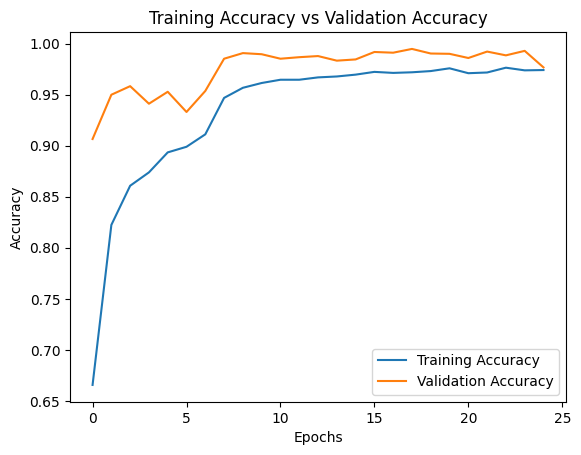

In [1]:
import matplotlib.pyplot as plt


epochs = [i for i in range(25)]
train_acc = [0.6656, 0.8224, 0.8608, 0.8739, 0.8935, 0.8990, 0.9112, 0.9469, 0.9568, 0.9615, 0.9647, 0.9647, 0.9670, 0.9679, 0.9697, 0.9724, 0.9714, 0.9720, 0.9732, 0.9759, 0.9711, 0.9718, 0.9765, 0.9739, 0.9742]
val_acc = [0.9066, 0.9500, 0.9584, 0.9412, 0.9529, 0.9331, 0.9537, 0.9853, 0.9908, 0.9897, 0.9853, 0.9868, 0.9879, 0.9834, 0.9846, 0.9919, 0.9912, 0.9949, 0.9904, 0.9901, 0.9860, 0.9923, 0.9886, 0.9930, 0.9768]



plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.legend()


plt.show()

In [32]:
torch.save(model_x,'xception-model1.pth')

In [20]:
from PIL import Image

In [21]:
image_path = 'D:/others/potatoearlyblight.jpg'

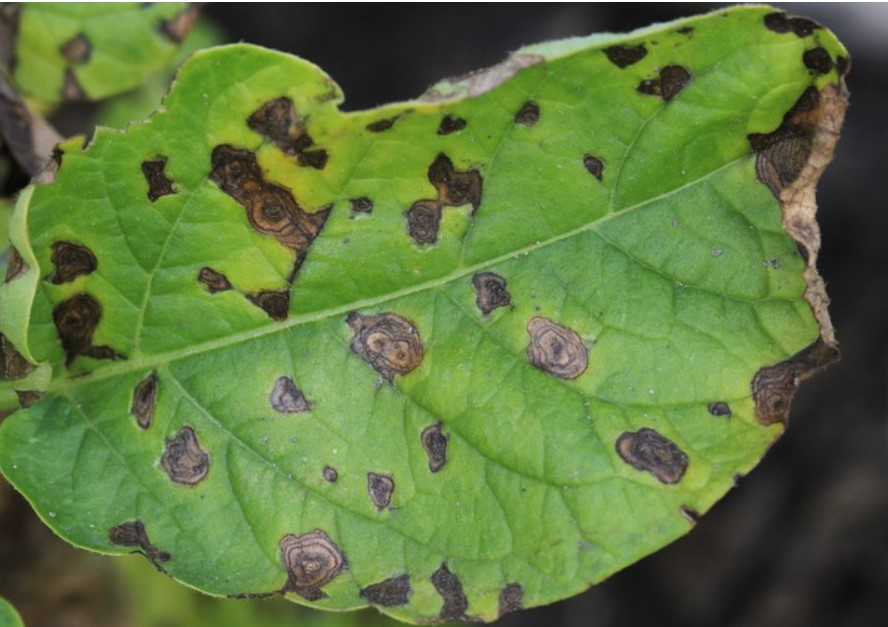

In [22]:
image = Image.open(image_path)
image

In [23]:
image = transforms['test'](image)  
image = image.unsqueeze(0)

In [24]:
image=image.to(device)

In [25]:
output = model_x(image)
output

tensor([[  3.8914, -11.4902, -22.0390, -18.4233,  -1.7827, -10.6771, -25.0742,
           2.8042, -20.4561, -15.2305, -40.1828, -21.1707, -18.3953]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [26]:
class_names

['Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [27]:
image_path = 'D:/others/tomatomosiacleaf.jpg'

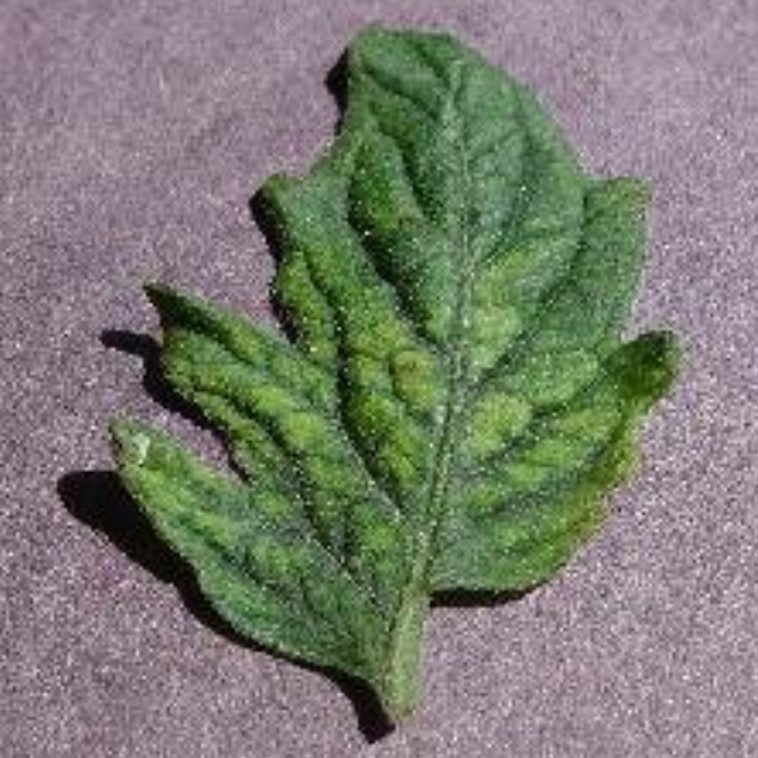

In [28]:
image = Image.open(image_path)
image

In [29]:
image = transforms['test'](image)  
image = image.unsqueeze(0)

In [30]:
image=image.to(device)

In [31]:
output = model_x(image)
output

tensor([[-39.9754, -25.9091, -17.0380, -36.9043, -14.1026, -29.0456, -18.7797,
         -16.0976, -16.6241, -15.3839, -12.0139,  24.6779, -35.1232]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [11]:
model_x=torch.load('xception-model1.pth')

In [12]:
model_x.eval()

Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU(inplace=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Conv

In [13]:
with torch.no_grad():
    
    accuracy = 0
    total_samples = 0
    correct_predictions = 0
    predicted_labels = []
    true_labels = []

    
    for images, labels in dataloaders['test']:
        images = images.to(device)
        labels = labels.to(device)

       
        outputs = model_x(images)

       
        _, predicted = torch.max(outputs.data, 1)

        
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        # Append predicted and true labels to lists
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

   
    accuracy = correct_predictions / total_samples

    precision = precision_score(true_labels, predicted_labels, average='weighted')
    
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    
    f_score = f1_score(true_labels, predicted_labels, average='weighted')

  
    confusion_mat = confusion_matrix(true_labels, predicted_labels)

print("Accuracy: {:.5f}%".format(accuracy))

Accuracy: 0.99397%


In [14]:
print("precision: {:.5f}".format(precision))

precision: 0.99415


In [15]:
print("recall: {:.5f}".format(recall))

recall: 0.99397


In [16]:
print("F-score:{:.5f}".format(f_score))

F-score:0.99399


In [15]:
print("Confusion Matrix:")
print(confusion_mat)

Confusion Matrix:
[[100   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  99   1   0   0   0   0   0   0   0   0   0   0]
 [  0   0  16   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 213   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 100   0   0   0   0   0   0   0   0]
 [  0   0   0   0   5 187   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  96   0   0   0   0   0   0]
 [  1   0   0   0   0   1   0 176   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 168   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 139   0   0   2]
 [  0   0   0   1   0   0   0   0   0   0 321   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  39   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 160]]


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

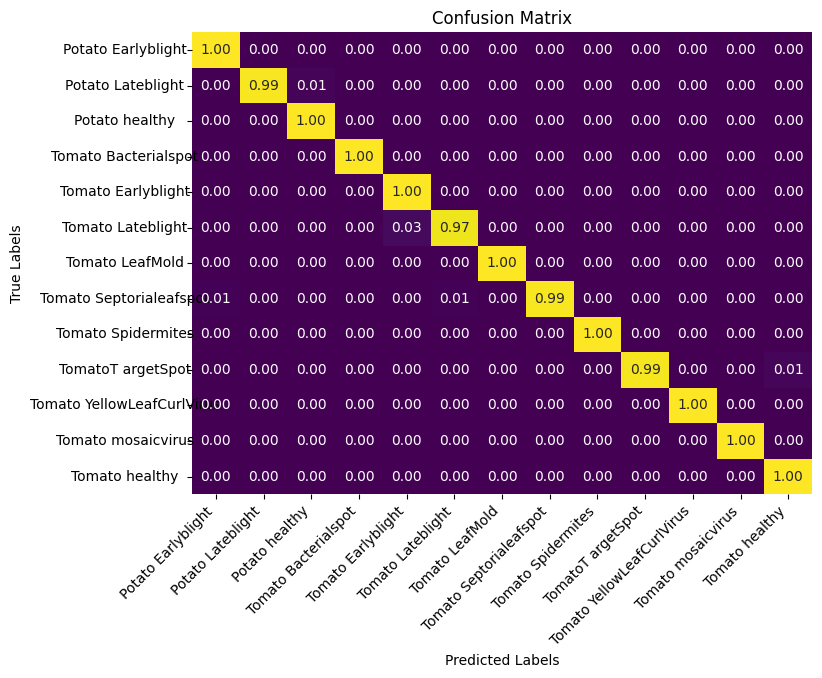

In [17]:

class_labels =  ['Potato Earlyblight','Potato Lateblight','Potato healthy','Tomato Bacterialspot','Tomato Earlyblight',
                 'Tomato Lateblight','Tomato LeafMold','Tomato Septorialeafspot','Tomato Spidermites','TomatoT argetSpot',
                 'Tomato YellowLeafCurlVirus','Tomato mosaicvirus','Tomato healthy']


normalized_confusion_mat = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8, 6))


heatmap = sns.heatmap(normalized_confusion_mat, annot=True, fmt='.2f', cmap='viridis', cbar=False, ax=ax)


ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')

heatmap.set_xticklabels(class_labels, rotation=45, ha='right')
heatmap.set_yticklabels(class_labels, rotation=0, ha='center')


ax.tick_params(axis='y', pad=45)


plt.xticks(rotation=45)




plt.show()

In [17]:
from torchsummary import summary

In [18]:
summary(model_x, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 111, 111]             864
       BatchNorm2d-2         [-1, 32, 111, 111]              64
              ReLU-3         [-1, 32, 111, 111]               0
            Conv2d-4         [-1, 64, 109, 109]          18,432
       BatchNorm2d-5         [-1, 64, 109, 109]             128
              ReLU-6         [-1, 64, 109, 109]               0
            Conv2d-7         [-1, 64, 109, 109]             576
            Conv2d-8        [-1, 128, 109, 109]           8,192
   SeparableConv2d-9        [-1, 128, 109, 109]               0
      BatchNorm2d-10        [-1, 128, 109, 109]             256
             ReLU-11        [-1, 128, 109, 109]               0
           Conv2d-12        [-1, 128, 109, 109]           1,152
           Conv2d-13        [-1, 128, 109, 109]          16,384
  SeparableConv2d-14        [-1, 128, 1